In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import yfinance as yf

In [78]:
# Data Retrieval 

ticker = 'MSFT' # Choose Ticker Here
data = yf.download(ticker, start='1900-01-01')
data.to_csv('stock_data.csv')

df = pd.read_csv('stock_data.csv')

df = df[['Date', 'Close']]

df

[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9626,2024-05-23,427.000000
9627,2024-05-24,430.160004
9628,2024-05-28,430.320007
9629,2024-05-29,429.170013


In [79]:
# Turning Date Column into Index
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split [1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)

df.index = df.pop('Date')

df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-05-23,427.000000
2024-05-24,430.160004
2024-05-28,430.320007


In [80]:
# Function to turn data into windowed data
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df, 
                                '2021-01-01', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-01-01,224.960007,224.149994,221.679993,222.419998
1,2021-01-05,221.679993,222.419998,217.690002,217.899994
2,2021-01-06,222.419998,217.690002,217.899994,212.250000
3,2021-01-07,217.690002,217.899994,212.250000,218.289993
4,2021-01-08,217.899994,212.250000,218.289993,219.619995
...,...,...,...,...,...
303,2022-03-17,276.440002,287.149994,294.390015,295.220001
304,2022-03-18,287.149994,294.390015,295.220001,300.429993
305,2022-03-21,294.390015,295.220001,300.429993,299.160004
306,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [81]:
# Function to turn windowed data into numpy array
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    dates = df_as_np[:,0]
    
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    
    Y = df_as_np[:, -1]
    
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((308,), (308, 3, 1), (308,))

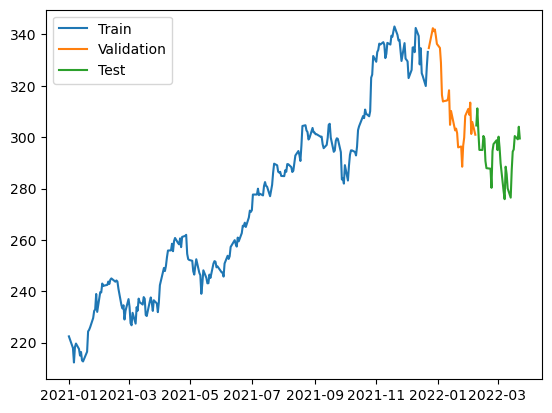

In [82]:
# Defining Training, Validation and Testing Data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [83]:
# Model Preparation & Fitting

model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
8/8 [==============================] - 3s 73ms/step - loss: 76639.6719 - mean_absolute_error: 274.5003 - val_loss: 98928.2031 - val_mean_absolute_error: 314.1526
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 76489.4609 - mean_absolute_error: 274.2245 - val_loss: 98766.7891 - val_mean_absolute_error: 313.8956
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 76346.8203 - mean_absolute_error: 273.9662 - val_loss: 98590.4844 - val_mean_absolute_error: 313.6145
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 76161.3594 - mean_absolute_error: 273.6277 - val_loss: 98331.8359 - val_mean_absolute_error: 313.2020
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 75926.3672 - mean_absolute_error: 273.1971 - val_loss: 98051.0469 - val_mean_absolute_error: 312.7535
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 75659.1484 - mean_absolute_error: 272.7061 - val_loss: 97676.13

1/1 [==============================] - 0s 22ms/step


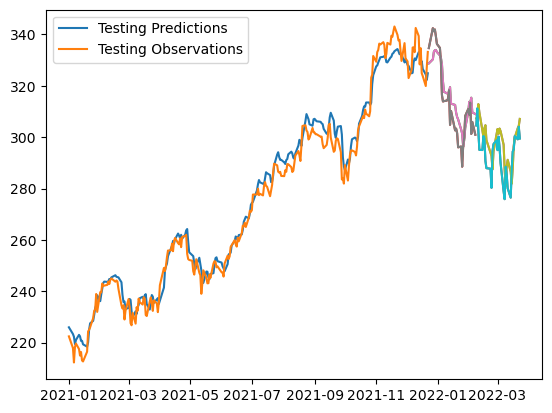

In [84]:
# Results Plotted

train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()


# All Results Plotted
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

# Validation Results Plotted 
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])


# Testing Reults Plotted
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

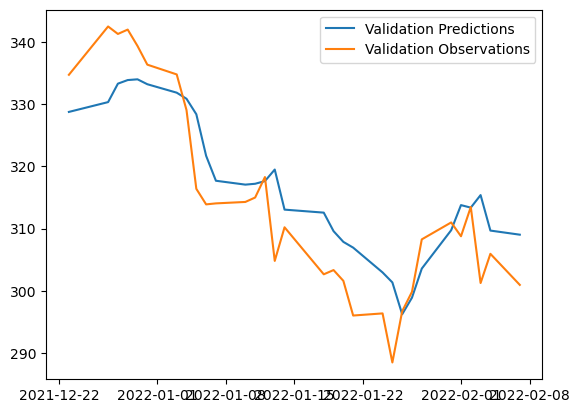

In [85]:
# Validation Results Plotted 
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

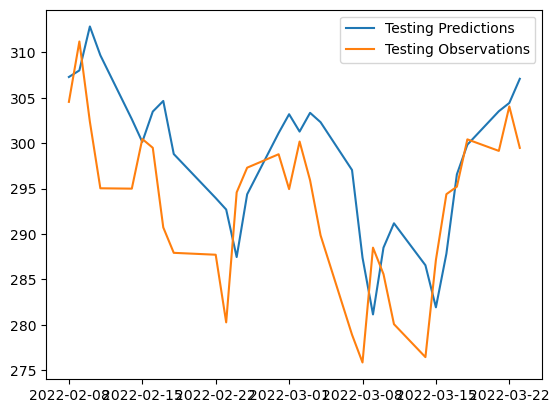

In [86]:
# Testing Reults Plotted
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])